In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants

mm = 1E-3
C = scipy.constants.c

def set_font(fontsize=18, font="Times New Roman"):
    rc = {"font.size" : fontsize,
    "font.family" : font,
    "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
set_font(fontsize=15)

def padortruncate(array, dx, dy, val_bg=0):
    '''
    Pads (with value val_bg) or truncates array depending on whether array dimensions are great than or less than (dx, dy)

    '''
    dx = int(dx)
    dy = int(dy)
    nx = max((dx-array.shape[1])//2, 0)
    ny = max((dy-array.shape[0])//2, 0)
    px = max((array.shape[1]-dx)//2, 0)
    py = max((array.shape[0]-dy)//2, 0)
    newarray = val_bg * np.ones((dy, dx), dtype=array.dtype)
    cx = min(array.shape[1], dx)
    cy = min(array.shape[0], dy)
    newarray[ny:ny+cy, nx:nx+cx] = array[py:py+cy, px:px+cx]

    return newarray

def fft_resample(img, height, width):
    '''
    Resamples image img by padding or truncating in the Fourier domain.

    '''
    img = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(img)))
    scal = img.size
    img = padortruncate(img, height, width)
    scal = img.size / scal
    img = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(img)))*scal

    return img

def G(k, R):
    return np.exp(-1j*k*R)/R

### Define antenna coordinates

In [2]:
d_antennas = .035        # MEASURE THIS, gives distance between tx/rx antennas
z_offset = 0.76
MAR = 2*z_offset        # maximum unambiguous range
delta_f = C/(2*MAR)
fc = 22E9
bw = 1E9
Nf = int(np.ceil(bw/delta_f))

f = np.linspace(fc-bw/2, fc+bw/2, Nf)
lam = C/f
k = 2*np.pi/lam

Lxa = .3
Lya = .3
delta_xa = np.amin(lam)/2
delta_ya = np.amin(lam)/2
xa = np.arange(-Lxa/2, Lxa/2+delta_xa, delta_xa)
ya = np.arange(-Lya/2, Lya/2+delta_ya, delta_ya)
Xa, Ya = np.meshgrid(xa, ya, indexing='xy')
Za = np.zeros_like(Xa)

Na = Xa.size
M = Na*Nf

### Create H matrix

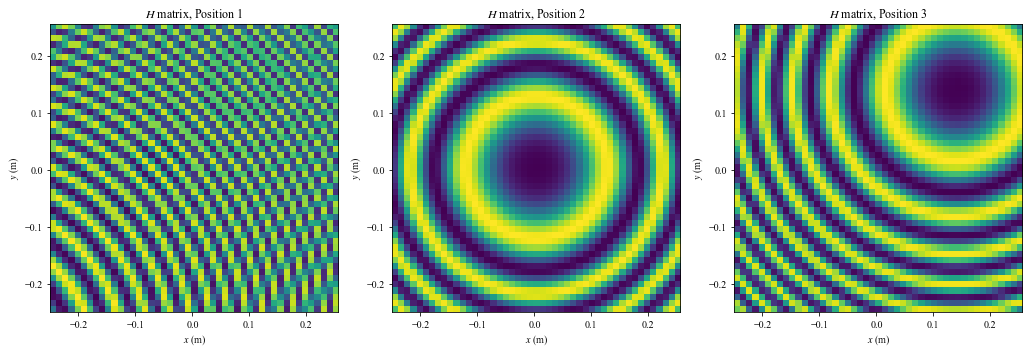

In [3]:
Lxs = .5
Lys = .5
Lzs = .00001

cr_res_x = np.amin(lam)*z_offset/(2*Lxa)
cr_res_y = np.amin(lam)*z_offset/(2*Lya)
r_res_z = C/bw

delta_xs = cr_res_x/2
delta_ys = cr_res_y/2
delta_zs = r_res_z/2

xs = np.arange(-Lxs/2, Lxs/2+delta_xs, delta_xs)
ys = np.arange(-Lys/2, Lys/2+delta_ys, delta_ys)
zs = np.arange(z_offset-Lzs/2, z_offset+Lzs/2+delta_zs, delta_zs)
Xs, Ys, Zs = np.meshgrid(xs, ys, zs, indexing='ij')

N = Xs.size                     # total number of scene positions

Xa1, Xs1 = np.meshgrid(Xa.flatten(), Xs.flatten(), indexing='ij')
Ya1, Ys1 = np.meshgrid(Ya.flatten(), Ys.flatten(), indexing='ij')
Za1, Zs1 = np.meshgrid(Za.flatten(), Zs.flatten(), indexing='ij')

Rt = np.sqrt((Xa1 + d_antennas/2 - Xs1)**2 + (Ya1 - Ys1)**2 + (Za1 - Zs1)**2)       # set of transmitter-scene distances
Rr = np.sqrt((Xa1 - d_antennas/2 - Xs1)**2 + (Ya1 - Ys1)**2 + (Za1 - Zs1)**2)       # set of receiver-scene distances

H = np.empty((Na, N, Nf), dtype=np.complex64)
for kk in range(k.size):
    # H[:,:,kk] = np.exp(-1j*k[kk]*Rt)/Rt * np.exp(-1j*k[kk]*Rr)/Rr
    H[:,:,kk] = G(k[kk], Rt) * G(k[kk], Rr)

set_font(fontsize=15)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plt.figaspect(float(1)/float(3)))
ax1.imshow(np.real(H[:,10,0]).reshape(Xa.shape), extent=(xs[0], xs[-1], ys[0], ys[-1]), origin='lower')
ax1.set_title('$H$ matrix, Position 1')
ax1.set_xlabel('$x$ (m)')
ax1.set_ylabel('$y$ (m)')
ax2.imshow(np.real(H[:,H.shape[1]//2,0]).reshape(Xa.shape), extent=(xs[0], xs[-1], ys[0], ys[-1]), origin='lower')
ax2.set_title('$H$ matrix, Position 2')
ax2.set_xlabel('$x$ (m)')
ax2.set_ylabel('$y$ (m)')
ax3.imshow(np.real(H[:,2*H.shape[1]//3,0]).reshape(Xa.shape), extent=(xs[0], xs[-1], ys[0], ys[-1]), origin='lower')
ax3.set_title('$H$ matrix, Position 3')
ax3.set_xlabel('$x$ (m)')
ax3.set_ylabel('$y$ (m)')
plt.tight_layout()
plt.show()

H = np.reshape(np.transpose(H, (0, 2, 1)), (M, N))

### Simulate signal

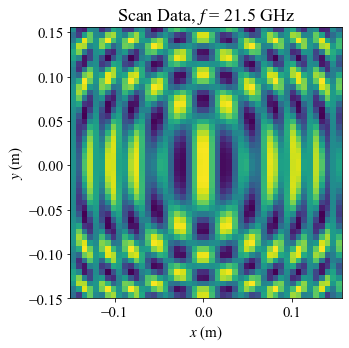

In [4]:
x_target = -0.1
y_target = 0.0
z_target = z_offset
target = np.array([x_target, y_target, z_target])[None,:]
target = np.concatenate((target, np.array([x_target+.2, y_target, z_target])[None,:]), axis=0)

measurements = np.zeros((ya.size, xa.size, Nf), dtype=np.complex64)
for t in range(target.shape[0]):
    Rt = np.sqrt((Xa + d_antennas/2 - target[t,0])**2 + (Ya - target[t,1])**2 + (Za - target[t,2])**2)
    Rr = np.sqrt((Xa - d_antennas/2 - target[t,0])**2 + (Ya - target[t,1])**2 + (Za - target[t,2])**2)
    for kk in range(f.size):
        measurements[:,:,kk] += G(k[kk], Rt) * G(k[kk], Rr)

g = np.reshape(measurements, (M, 1))

set_font(fontsize=15)
fig = plt.figure(figsize=(5,5))
plt.imshow(np.real(measurements[:,:,0]),
           extent=(np.amin(xa), np.amax(xa), np.amin(ya), np.amax(ya)),
           origin='lower')
plt.title('Scan Data, $f$ = {} GHz'.format(f[0]*1E-9))
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.show()

### Reconstruct

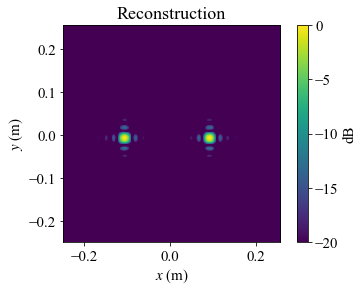

In [5]:
im = np.transpose((np.transpose(np.conjugate(H)) @ g).reshape(Xs.shape), (1, 0, 2))
im = np.abs(np.mean(im, 2))**2

N_interp = 3
im_interpolate = np.abs(fft_resample(im, N_interp*im.shape[0], N_interp*im.shape[1]))
im_interpolate = 10*np.log10(im_interpolate/np.amax(im_interpolate))

set_font(fontsize=15)
plt.figure()
plt.imshow(im_interpolate,
           extent=(np.amin(xs), np.amax(xs), np.amin(ys), np.amax(ys)),
           origin='lower')
plt.clim(-20, 0)
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.title('Reconstruction')
plt.colorbar(label='dB')
plt.show()